In [1]:
#!pip install editdistance
#!pip install transformers
#!pip install pytorch
#!pip install Bio
#!pip install biopython 
#!pip install strkernel
import pickle
from strkernel.mismatch_kernel import preprocess
from scipy import cluster
from strkernel.mismatch_kernel import MismatchKernel
from Bio import Phylo
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import editdistance
import pickle
from transformers import BertForMaskedLM, BertTokenizer, pipeline
from Bio.Seq import Seq
import strkernel
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import DBSCAN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import Input, LSTM, GRU, Bidirectional

from keras import backend as K 
from tensorflow.keras.layers import Dropout
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.models import Model

In [2]:
import networkx 
from networkx.algorithms.components.connected import connected_components
def to_graph(l):
    G = networkx.Graph()
    for part in l:
        # each sublist is a bunch of nodes
        G.add_nodes_from(part)
        # it also imlies a number of edges:
        G.add_edges_from(to_edges(part))
    return G
def to_edges(l):
    it = iter(l)
    last = next(it)
    for current in it:
        yield last, current
        last = current    

Load data

In [3]:
os.chdir('C:/Users/gregb/OneDrive/Asztali gép/UPC_master/BIOINF/Final Assignment/data')
data=pd.read_csv('train.csv')
data=data.set_index('seq_id')

## Descriptive analytics

In [4]:
len(data)

31390

In [5]:
data.protein_sequence.nunique()

28981

In [6]:
data.describe()

,pH,tm
count,31104.000000,31390.000000
mean,6.892339,49.147337
std,1.612225,14.010089
min,1.990000,-1.000000
25%,7.000000,42.100000
50%,7.000000,48.000000
75%,7.000000,53.800000
max,64.900000,130.000000


In [7]:
len(data.pH[data.pH > 14])

29

In [8]:
data.pH[data.pH > 14] = 7

In [9]:
data.pH.max()

11.0

In [10]:
pd.set_option('display.max_colwidth', -1)
data[data.duplicated(['protein_sequence','pH','tm'])].head()

,protein_sequence,pH,data_source,tm
seq_id,,,,
13058,MISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPVIMGRHTWESIGRPLPGRKNIILSSQPGTDDRVTWVKSVDEAIAACGDVPEIMVIGGGRVYEQFLPKAQKLYLTHIDAEVELDTHFPDYEPDDWESVFSEFHDADAQNSHSYCFEILERR,7.0,10.1093/oxfordjournals.jbchem.a124499,44.1
13062,MISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPVIMGRHTWESIGRPLPGRKNIILSSQPGTDDRVTWVKSVDEAIAACGDVPEIMVIGGGRVYEQFLPKAQKLYLTHIDAEVEVDTHFPDYEPDDWESVFSEFHDADAQNSHSYCFEILERR,7.0,10.1093/oxfordjournals.jbchem.a124499,46.9
13327,MKALIVLGLVLLSVTVQGKVFERCELARTLKRLGMDGYRGISLANWMCLAKWESGYNTRATNYNAGDGSTDYGIFQINSRYWCNDGKTPGAVNACHLSCSALLQDNIADAVACAKRVVRDPQGIRAWVAWRNRCQNRDVRQYVQGCGV,2.7,10.1093/protein/12.8.663,65.8
13335,MKALIVLGLVLLSVTVQGKVFERCELARTLKRLGMDGYRGISLANWMCLAKWESGYNTRATNYNAGDRSTDYGAFQINSRYWCNDGKTPGAVNACHLSCSALLQDNIADAVACAKRVVRDPQGIRAWVAWRNRCQNRDVRQYVQGCGV,2.7,10.1006/jmbi.1997.1365,52.4
13342,MKALIVLGLVLLSVTVQGKVFERCELARTLKRLGMDGYRGISLANWMCLAKWESGYNTRATNYNAGDRSTDYGIFGINSRYWCNDGKTPGAVNACHLSCSALLQDNIADAVACAKRVVRDPQGIRAWVAWRNRCQNRDVRQYVQGCGV,2.7,10.1021/bi9928694,70.6


In [11]:
#Delete real dupes (all values same)
data=data.drop_duplicates(subset=['protein_sequence','pH','tm'], keep="first")

In [12]:
#Delete all lines where we have inconsistent data
dupl_idx = data[data.duplicated(['protein_sequence','pH'])].index
data=data.loc[~ data.index.isin(dupl_idx)]

In [13]:
data[data.protein_sequence=='QDWLTFQKKHITNTRDVDCDNILSTNLFHCKDKNTFIYSRPEPVKAICKGIIASKNVLTTSEFYLSDCNVTSRPCKYKLKKSTNKFCVTCENQAPVHFVGVGSC'].head(3)

,protein_sequence,pH,data_source,tm
seq_id,,,,
29841,QDWLTFQKKHITNTRDVDCDNILSTNLFHCKDKNTFIYSRPEPVKAICKGIIASKNVLTTSEFYLSDCNVTSRPCKYKLKKSTNKFCVTCENQAPVHFVGVGSC,3.0,10.1021/bi000415x,68.9
29842,QDWLTFQKKHITNTRDVDCDNILSTNLFHCKDKNTFIYSRPEPVKAICKGIIASKNVLTTSEFYLSDCNVTSRPCKYKLKKSTNKFCVTCENQAPVHFVGVGSC,6.0,10.1021/bi000415x,82.8
29843,QDWLTFQKKHITNTRDVDCDNILSTNLFHCKDKNTFIYSRPEPVKAICKGIIASKNVLTTSEFYLSDCNVTSRPCKYKLKKSTNKFCVTCENQAPVHFVGVGSC,2.5,10.1021/bi000415x,65.8


In [14]:
len(data)

29983

In [15]:
data[data.duplicated(['protein_sequence'])].protein_sequence.nunique()

536

In [16]:
data['sequence_length']=data.protein_sequence.apply(lambda x: len(x))

In [17]:
os.chdir('C:/Users/gregb/OneDrive/Asztali gép/UPC_master/BIOINF/Final Assignment/data')
#data.to_csv('cleaned_data.csv',index=False)

In [18]:
#Plots are created in R

In [19]:
data.sequence_length.describe()

count    29983.000000
mean     458.740686  
std      652.362157  
min      5.000000    
25%      209.000000  
50%      346.000000  
75%      536.000000  
max      32767.000000
Name: sequence_length, dtype: float64

In [20]:
len(data[data.sequence_length<1000])/len(data)

0.9310609345295667

In [21]:
data.pH.describe()

count    29699.000000
mean     6.886655    
std      0.773169    
min      1.990000    
25%      7.000000    
50%      7.000000    
75%      7.000000    
max      11.000000   
Name: pH, dtype: float64

In [22]:
len(data[data.pH==7])/len(data)

0.8636560717740053

In [23]:
data.tm.describe()

count    29983.000000
mean     49.294847   
std      13.815969   
min      0.000000    
25%      42.200000   
50%      48.000000   
75%      53.700000   
max      130.000000  
Name: tm, dtype: float64

## Clustering

### ClustalW

In [36]:
os.chdir('C:/Users/gregb/OneDrive/Asztali gép/UPC_master/BIOINF/Final Assignment/clustering/clustalw')

In [21]:
import os
from Bio.Align.Applications import ClustalwCommandline
clustalw_exe = r"C:/Program Files (x86)/ClustalW2/ClustalW2.exe"
clustalw_cline = ClustalwCommandline(clustalw_exe, infile="clustal_test.fasta")

In [26]:
print(clustalw_cline)

"C:/Program Files (x86)/ClustalW2/ClustalW2.exe" -infile=clustal_test.fasta


In [29]:
clustalw_cline()

('\n\n\n CLUSTAL 2.1 Multiple Sequence Alignments\n\n\nSequence format is Pearson\nSequence 1: sequence5   1451 aa\nSequence 2: sequence6    380 aa\nSequence 3: sequence7    380 aa\nSequence 4: sequence8    301 aa\nSequence 5: sequence9    287 aa\nSequence 6: sequence10   163 aa\nStart of Pairwise alignments\nAligning...\n\nSequences (1:2) Aligned. Score:  7\nSequences (1:3) Aligned. Score:  7\nSequences (1:4) Aligned. Score:  11\nSequences (1:5) Aligned. Score:  12\nSequences (1:6) Aligned. Score:  12\nSequences (2:3) Aligned. Score:  99\nSequences (2:4) Aligned. Score:  5\nSequences (2:5) Aligned. Score:  3\nSequences (2:6) Aligned. Score:  7\nSequences (3:4) Aligned. Score:  5\nSequences (3:5) Aligned. Score:  3\nSequences (3:6) Aligned. Score:  7\nSequences (4:5) Aligned. Score:  1\nSequences (4:6) Aligned. Score:  3\nSequences (5:6) Aligned. Score:  14\nGuide tree file created:   [clustal_test.dnd]\n\nThere are 5 groups\nStart of Multiple Alignment\n\nAligning...\nGroup 1:        

In [30]:
from Bio import AlignIO
align = AlignIO.read(open("clustal_test.aln"), "clustal")
print(align)

Alignment with 6 rows and 1453 columns
--------------------------------------------...--- sequence6
--------------------------------------------...--- sequence7
AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNC...ITT sequence5
--------------------------------------------...--- sequence10
--------------------------------------------...--- sequence9
--------------------------------------------...--- sequence8


In [ ]:
#Phylogenetic tree

In [31]:
tree = Phylo.read("clustal_test.dnd","newick")

In [32]:
Phylo.draw_ascii(tree)

     _____________________________________________________ sequence5
  __|
 |  |    __________________________________________________________ sequence9
 |  |___|
 |      |_______________________________________________________ sequence10
_|
 |                                                             , sequence6
 |_____________________________________________________________|
 |                                                             | sequence7
 |
 |____________________________________________________________ sequence8



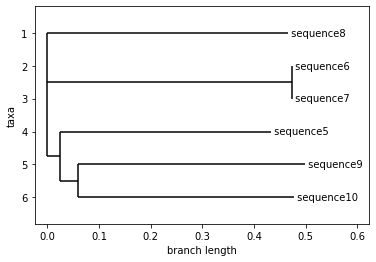

In [51]:
tree = Phylo.read("clustal_test.dnd", "newick")
tree.ladderize()  # Flip branches so deeper clades are displayed at top
Phylo.draw(tree, do_show=False)
#plt.savefig('phylo.png', dpi=200)

In [ ]:
#Time efficiency of MSA

In [19]:
import time

In [22]:
start_time = time.time()
clustalw_exe = r"C:/Program Files (x86)/ClustalW2/ClustalW2.exe"
clustalw_cline = ClustalwCommandline(clustalw_exe, infile="clustal_test.fasta")
clustalw_cline()
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.7215745449066162 seconds ---


In [23]:
start_time = time.time()
clustalw_exe = r"C:/Program Files (x86)/ClustalW2/ClustalW2.exe"
clustalw_cline = ClustalwCommandline(clustalw_exe, infile="clustal50.fasta")
clustalw_cline()
print("--- %s seconds ---" % (time.time() - start_time))

--- 44.76201343536377 seconds ---


In [24]:
start_time = time.time()
clustalw_exe = r"C:/Program Files (x86)/ClustalW2/ClustalW2.exe"
clustalw_cline = ClustalwCommandline(clustalw_exe, infile="clustal100.fasta")
clustalw_cline()
print("--- %s seconds ---" % (time.time() - start_time))

--- 96.20336818695068 seconds ---


In [25]:
start_time = time.time()
clustalw_exe = r"C:/Program Files (x86)/ClustalW2/ClustalW2.exe"
clustalw_cline = ClustalwCommandline(clustalw_exe, infile="clustal300.fasta")
clustalw_cline()
print("--- %s seconds ---" % (time.time() - start_time))

--- 512.0631942749023 seconds ---


In [26]:
start_time = time.time()
clustalw_exe = r"C:/Program Files (x86)/ClustalW2/ClustalW2.exe"
clustalw_cline = ClustalwCommandline(clustalw_exe, infile="clustal500.fasta")
clustalw_cline()
print("--- %s seconds ---" % (time.time() - start_time))

--- 1201.926085948944 seconds ---


In [27]:
start_time = time.time()
clustalw_exe = r"C:/Program Files (x86)/ClustalW2/ClustalW2.exe"
clustalw_cline = ClustalwCommandline(clustalw_exe, infile="clustal1000.fasta")
clustalw_cline()
print("--- %s seconds ---" % (time.time() - start_time))

--- 3468.5876388549805 seconds ---


### Edit distance

In [25]:
data=data.reset_index(drop=True)

In [26]:
os.chdir('C:/Users/gregb/OneDrive/Asztali gép/UPC_master/BIOINF/Final Assignment/clustering/edit')

Explanation step by step

In [56]:
sequences=data.protein_sequence
lengths=data.protein_sequence.apply(lambda x: len(x))
#Count how many different lengths there are
unique_lengths=lengths.unique()
length_active=min(unique_lengths)

#Sequence indx where the length is within thresholds
good_indices=lengths[(lengths > length_active-3) & (lengths < length_active+3)].index.to_list()
#Mark subset of sequences with these index
subtable=sequences.loc[good_indices]

In [57]:
subtable

28876    RPAVT  
28883    RPGSI  
29482    TVIHLVG
Name: protein_sequence, dtype: object

In [64]:
#Find edit distances - make a matrix of distances
distances=[]
for row_1 in range(len(subtable)):
    one_row=[]
    for row_2 in range(len(subtable)):
        if row_1 == row_2:
            one_row.append(np.nan)
        elif row_1 <= row_2:
            one_row.append(np.nan)
        else:
            one_row.append(editdistance.eval(subtable.iloc[row_1], subtable.iloc[row_2]))
    distances.append(one_row)
distances=pd.DataFrame(distances)
distances.columns=subtable.index.to_list()
distances.index=subtable.index.to_list()
binary=(distances<10)

In [65]:
distances

,28876,28883,29482
28876,NaN,NaN,NaN
28883,3.0,NaN,NaN
29482,6.0,7.0,NaN


In [66]:
binary

,28876,28883,29482
28876,False,False,False
28883,True,False,False
29482,True,True,False


In [67]:
#Tuples of pairs
mutations_pairs=binary[binary > 0].stack().index.tolist()

In [68]:
mutations_pairs

[(28883, 28876), (29482, 28876), (29482, 28883)]

Big loop

In [95]:
def make_pairs(sequences, indel_thr, dist_thr):
    lengths=sequences.apply(lambda x: len(x))
    #Count how many different lengths there are
    unique_lengths=lengths.unique()

    all_pairs=[]
    for i in range(len(unique_lengths)):
        length_active=unique_lengths[i]

        #Sequence indx where the length is within thresholds
        good_indices=lengths[(lengths > length_active-indel_thr) & (lengths < length_active+indel_thr)].index.to_list()
        #Mark subset of sequences with these index
        subtable=sequences.loc[good_indices]

            #Find edit distances - make a matrix of distances
        distances=[]
        for row_1 in range(len(subtable)):
            one_row=[]
            for row_2 in range(len(subtable)):
                if row_1 == row_2:
                    one_row.append(np.nan)
                elif row_1 <= row_2:
                    one_row.append(np.nan)
                else:
                    one_row.append(editdistance.eval(subtable.iloc[row_1], subtable.iloc[row_2]))
            distances.append(one_row)
        distances=pd.DataFrame(distances)
        distances.columns=subtable.index.to_list()
        distances.index=subtable.index.to_list()
        binary=(distances<dist_thr)
        #Tuples of pairs
        mutations_pairs=binary[binary > 0].stack().index.tolist()
        all_pairs+=mutations_pairs
    return(all_pairs)

In [96]:
pairs_found = make_pairs(data.protein_sequence,3,10)

In [97]:
len(pairs_found)

2547621

In [98]:
#with open('edit_pairs.pickle', 'wb') as f:
#    pickle.dump(pairs_found, f)

In [113]:
os.chdir('C:/Users/gregb/OneDrive/Asztali gép/UPC_master/BIOINF/Final Assignment/clustering/edit')
with open('edit_pairs.pickle', 'rb') as f:
    pairs_found = pickle.load(f)

In [117]:
[2121,2254] in done

True

In [102]:
G = to_graph(pairs_found)
final = connected_components(G)
done=[]
for comp in final:
    done.append(list(comp))

In [103]:
done[:5]

[[8830, 8831],
 [13944, 13942, 13943],
 [23002, 23003],
 [3625, 3626],
 [3892, 3893, 3894]]

In [104]:
#Add clusters to the original data

In [118]:
data['edit_groups']=np.nan
for i in range(len(done)):
    data.loc[done[i],['edit_groups']] = i

In [119]:
data[~data.edit_groups.isna()].head(2)

,protein_sequence,pH,data_source,tm,sequence_length,edit_groups,kernel_groups,kernel_count,edit_count
5,AACFWRRTVIPKPPFRGISTTSARSTVMPAWVIDKYGKNEVLRFTQNMMLPIIHYPNEVIIKVHAASVNPIDVNMRSGYGATALNMKRDPLHMKTKGEEFPLTLGRDVSGVVMECGLDVKYFQPGDEVWAAVPPWKQGTLSEFVVVSGNEVSHKPKSLTHTQAASLPYVALTAWSAINKVGGLSDKNCKGKRALILGASGGVGTFAIQVMKAWGAHVTAVCSKDASELVRKLGADEVIDYTLGSVEEQLKSLKLFDFILDNVGGSTETWALNFLKKWSGATYVTLVTPFLLNMDRLGVADGMLQTGVTVGTKALKHLWQGVHYRWAFFMASGPYLDEIAELVDAGKIRPVIERTFPFSEVPEAFLKVERGHARGKTVVNV,7.0,doi.org/10.1038/s41592-020-0801-4,48.4,380,10.0,5,2,2
6,AACFWRRTVIPKPPFRGISTTSARSTVMPAWVIDKYGKNEVLRFTQNMMLPIIHYPNEVIIKVHAASVNPIDVNMRSGYGATALNMKRDPLHMKTKGEEFPLTLGRDVSGVVMECGLDVKYFQPGDEVWAAVPPWKQGTLSEFVVVSGNEVSHKPKSLTHTQAASLPYVALTAWSAINKVGGLSDRNCKGKRALILGASGGVGTFAIQVMKAWGAHVTAVCSKDASELVRKLGADEVIDYTLGSVEEQLKSLKLFDFILDNVGGSTETWALNFLKKWSGATYVTLVTPFLLNMDRLGVADGMLQTGVTVGTKALKHLWQGVHYRWAFFMASGPYLDEIAELVDAGKIRPVIERTFPFSEVPEAFLKVERGHARGKTVVNV,7.0,doi.org/10.1038/s41592-020-0801-4,45.7,380,10.0,5,2,2


In [120]:
data.loc[[2121,2254]]

,protein_sequence,pH,data_source,tm,sequence_length,edit_groups,kernel_groups,kernel_count,edit_count
2121,KEKIRIRLKAYDHRILDQSAEKIVETAKRSGAKVSGPIPLPTERTVYTILRAVHKYKDSREQFEMRTHKRLIDIINPTPQTVDSLMRLDLPSGVDIEIK,7.0,doi.org/10.1038/s41592-020-0801-4,63.1,99,214.0,1957,1,2
2254,KQKIRIRLKAYDHRILDQSAEKIVETAKRSGASVSGPIPLPTEKSVYTILRAVHKYKDSREQFEMRTHKRLIDIVNPTPQTVDALMRLDLPSGVDIEIK,7.0,doi.org/10.1038/s41592-020-0801-4,41.7,99,214.0,2083,1,2


In [33]:
#Number of groups with more than 1 sequence
data.edit_groups.nunique()-1

392

In [112]:
(2254, 2121) in pairs_found

True

In [34]:
#Number of sequences in these
len(data[~data.edit_groups.isna()])

5908

In [35]:
#Fill the rest of the NaN with increasing numbers
max_groups=int(data.edit_groups.max())
data.loc[data[data.edit_groups.isna()].index,['edit_groups']]=range(max_groups+1,max_groups+1+len(data[data.edit_groups.isna()]))

In [36]:
data.edit_groups.nunique()

24468

### Kernel

In [37]:
os.chdir('C:/Users/gregb/OneDrive/Asztali gép/UPC_master/BIOINF/Final Assignment/clustering/kernel')

In [91]:
#Toy example

In [259]:
l=20 #Aminoacids
k=3 #K-mer length
m=1 #Number of mismatches allowed

In [260]:
sequences = ['APLPQKNSARHT','APLPQKNS', 'RKNSSSEIWMTN','DDRTILMTLFPAD', 'ADRTILMTLFPAD']
after_process = preprocess(sequences, ignoreLower=False)
mismatch_kernel = MismatchKernel(l=l, k=k, m=m).get_kernel(after_process)
similarity_mat = mismatch_kernel.kernel

In [261]:
print(similarity_mat.round(2))

[[1.   0.17 0.16 0.06 0.06]
 [0.17 1.   0.14 0.16 0.16]
 [0.16 0.14 1.   0.02 0.02]
 [0.06 0.16 0.02 1.   0.89]
 [0.06 0.16 0.02 0.89 1.  ]]


In [ ]:
#Real data

In [38]:
sequences=data.protein_sequence.tolist()

In [39]:
l=20 #Aminoacids
k=3 #K-mer length
m=0 #Number of mismatches allowed

In [40]:
after_process = preprocess(sequences)
mismatch_kernel = MismatchKernel(l=l, k=k, m=m).get_kernel(after_process)

In [41]:
similarity_mat = mismatch_kernel.kernel
os.chdir('C:/Users/gregb/OneDrive/Asztali gép/UPC_master/BIOINF/Final Assignment/clustering/kernel')
pickle.dump(similarity_mat, open("similarity_mat.bin", "wb"))

In [96]:
#Checkpoint
os.chdir('C:/Users/gregb/OneDrive/Asztali gép/UPC_master/BIOINF/Final Assignment/clustering/kernel')
similarity_mat = pickle.load(open("similarity_mat.bin", "rb"))

In [42]:
similarity_mat.shape

(29983, 29983)

In [43]:
#Substract similarities from 1
distance_matrix = np.ones(shape=(29983, 29983))-similarity_mat
del similarity_mat

In [44]:
clustering = DBSCAN(metric='precomputed', eps=0.05,min_samples=1)
clustering.fit(distance_matrix)

DBSCAN(eps=0.05, metric='precomputed', min_samples=1)

In [45]:
list(clustering.labels_)[:7]

[0, 1, 2, 3, 4, 5, 5]

In [46]:
data['kernel_groups']=clustering.labels_

In [47]:
auxiliar=pd.DataFrame(data.kernel_groups.value_counts()).reset_index().rename(columns={'kernel_groups':'count','index':'kernel_groups'})
data=data.merge(auxiliar, on='kernel_groups', how='left')

In [48]:
#Number of groups with more than 1 sequence
data[data['count']>1].kernel_groups.nunique()

3087

In [49]:
#Sequences in them
len(data[data['count']>1])

12780

In [50]:
data=data.drop('count', axis=1)

In [60]:
#Save data with cluster columns
os.chdir('C:/Users/gregb/OneDrive/Asztali gép/UPC_master/BIOINF/Final Assignment/clustering/')
data.to_csv('data_with_clusters.csv',index=False)

### Clustering Evaluation

In [64]:
os.chdir('C:/Users/gregb/OneDrive/Asztali gép/UPC_master/BIOINF/Final Assignment/clustering/')
data=pd.read_csv('data_with_clusters.csv')

In [65]:
from sklearn import metrics
metrics.rand_score(labels_true = data.edit_groups,
                   labels_pred = data.kernel_groups)

0.9998792547271239

In [90]:
metrics.adjusted_rand_score(labels_true = data.edit_groups,
                   labels_pred = data.kernel_groups)

0.9459040382838338

In [68]:
#Unbiased subset
auxiliar=pd.DataFrame(data.kernel_groups.value_counts()).reset_index().rename(columns={'kernel_groups':'kernel_count','index':'kernel_groups'})
data=data.merge(auxiliar, on='kernel_groups', how='left')
auxiliar=pd.DataFrame(data.edit_groups.value_counts()).reset_index().rename(columns={'edit_groups':'edit_count','index':'edit_groups'})
data=data.merge(auxiliar, on='edit_groups', how='left')

In [91]:
val_subset=data[(data.kernel_count>1) | (data.edit_count>1)]
metrics.rand_score(labels_true = val_subset.edit_groups,
                   labels_pred = val_subset.kernel_groups)

0.9993474786147815

In [92]:
metrics.adjusted_rand_score(labels_true = val_subset.edit_groups,
                   labels_pred = val_subset.kernel_groups)

0.945636320219413

In [ ]:
#examples

In [146]:
example1=data[(data.kernel_count==1) & (data.edit_count==2)]

In [138]:
example1.sort_values(['sequence_length']).head(2)

,protein_sequence,pH,data_source,tm,sequence_length,edit_groups,kernel_groups,kernel_count,edit_count
7734,MDNKTPVTLAKVIKVLGRTGSRGGVTQVRVEFLEDTSRTIVRNVKGPVRENDILVLMESEREARRL,7.0,doi.org/10.1038/s41592-020-0801-4,50.0,66,309.0,5534,1,2
8052,MDSKTPVTLAKVIKVLGRTGSRGGVTQVRVEFLEDTSRTIVRNVKGPVRENDILVLMESEREARRL,7.0,doi.org/10.1038/s41592-020-0801-4,47.6,66,309.0,5771,1,2


In [139]:
example2=data[(data.kernel_count==2) & (data.edit_count==1)]

In [145]:
example2.sort_values('kernel_groups').head(50)

,protein_sequence,pH,data_source,tm,sequence_length,edit_groups,kernel_groups,kernel_count,edit_count
36,ACFDNDKEVKGACFKFVNQQLTFNDARNWCHYQNPVTSSYLAYVPDQYTSSFVAAYARTAFGTNYGNFWIGLSRNSSSSPFAWDNGSPVAYTNFDTQFGQNYIAEKIVNSKWTAFGEKDKNFFVCSYNPTFSPAIISTTQEPTTEGNSCQPVDRMTLLFAYSNDLDPQAVNNSWNWAGINLYSTFSGFAFARFDVRDEEDIAYFTDFESATSYLHSHLPDSSLGFGDNNTGSDSLVTIEKFYNSKEIPVCGAISMILSKRYPDDWNLPRTVSLVREHHGIVHAVSSVDPSGGTPSNALYNLTSKTNGMSNFGTDDGFPRLVGLISFNYGPQPIYCANPEVSGQNTIELPAIDILSSESYWVSVLTQDHGPLDAFQSFNLTWSSSEYGGNTLNSSSTQGLYGLVGLNWFPFNAETYSMKLQYNYINNINEVIQVRLYGVRAQRDWLPYC,7.0,doi.org/10.1038/s41592-020-0801-4,41.2,448,NaN,35,2,1
37,ACFDNGDKEIQGMCFKLVPQMLTYQDARDWCHYKNPVTSSNLAYVPNQFTANFLASYARSAFGSNDGYFWIGLSRTSSNSPFTWDNGQPLGYTNFGTQLGQNYIAESIVNTKWNAFGASDKNFFVCSYDPAAPPTFSPLPTRMPETTMMPMPTTT,7.0,doi.org/10.1038/s41592-020-0801-4,52.4,155,NaN,35,2,1
40,ACPDSNDKEIRGFCFKFVVQKMAYNDARNWCHYQNPVGPSYLAVVGNKETNNNLAVYARSAFGASAEYFWIGLSRNGSSGALTWDNGFPVIYTNFGSHVGNNYFTEKISNSKWDTPGDSEKNYFVCSYDPTVQPVTPKATTPTTTTAANVNCPLGGQQTVLFAYSNDLVPSVVLNTFSSSYLNSQPVTIAISRFDTRQPQSMMYFNDYNQAYSYLSTNLPDSTLGFGDSTAGSNVLDVINNFYSSPSACGSVVMVLAKRYPNTTDISNTVAKVRQYHGIVNFLASNTPSGGTQSRVLFDLASKTNGIYSIDDDSTFSHFIGWMPLRERYPIYAVNPKVSGQGSQTLSPMSVPRYAQYLMMVTVQSHVPVSNVQSATLGWHNQSSSYSGIFGMQPAGWEYINSNDDGTRENIDANVFNMTIDYVYTNTDVETMQIRFYSPYATTYWLPYS,7.0,doi.org/10.1038/s41592-020-0801-4,45.7,449,NaN,38,2,1
41,ACPDSNDKEIRGFCFKFVVQKMTYNDARNWCHYQNPVGPSYLAVVGNKETNNNLAVYARSAFGASAEYFWIGLSRNGSSGSLSWDNGFPVIYTNFGSHVGNNYFTEKISNTKWDTPGDNEKNYFVCSYDPTVQPVTPKATTPTTTTAANVNCQLGGQQTVLFAYSNDLAPSVVLNTFSNSYLNEQLVTIAISRFDTRQPQSIMYFSDYIQAYTYVSSHLPDSTLGFGDSTTGSNVLDVINNFYNDISSCGSVVMVLSKRYPNTMDISSTVAKVRQYHGMVNFLASNAPSGGTQSRVLFDLSSRTNGIYSIEEDATFLHFIGWMPLRERYPIYAVNVKVSGHGSQVLPPMSVPRDVTYLIMVSLQSHLPISNVQSAKLNWFNPPFPQGALSMQPSEWAYTNSNSGGNRRIIDPAVYNMTIDYIYTNTDVETMQIRFYSSFYTNSWIPYS,7.0,doi.org/10.1038/s41592-020-0801-4,49.9,448,NaN,38,2,1
139,AENDLTQLANKVAVILENHEDQALARSITWELADNLTSIAIIQDEKNHWYSPNDKNRLSSITVEQIQHDKDLNKALKDHKKVSKRTGLSDTDTDNERLIVGVPYEKDGKKGMVFLSQSLLAVKDTTKHTTRYIFLAAGIAIVLTTFFAFFLSSRVTYPLRKMREGAQDLAKGKFDTKIPILTQDEIGELATAFNQMGRQLNFHINALNQEKEQLSNILSSMADGVITINIDGTILVTNPPAERFLQAWYYEQNMNIKEGDNLPPEAKELFQNAVSTEKEQMIEMTLQGRSWVLLMSPLYAESHVRGAVAVLRDMTEERRLDKLREDFIANVSHELRTPISMLQGYSEAIVDDIASSEEDRKEIAQIIYDESLRMGRLVNDLLDLARMESGHTGLHYEKINVNEFLEKIIRKFSGVAKEKNIALDHDISLTEEEFMFDEDKMEQVFTNLIDNALRHTSAGGSVSISVHSVKDGLKIDIKDSGSGIPEEDLPFIFERFYKADKARTRGRAGTGLGLAIVKNIVEAHNGSITVHSRIDKGTTFSFYIPTK,7.0,doi.org/10.1038/s41592-020-0801-4,43.2,547,NaN,120,2,1
140,AENDLTRLATKVAEVMHDYRDEQLARSIAWTLVDNRTKAVIVADESHYWYSPGDAGLDNMPLSSIRQDRDLRRVLTDGKTVKKRLYMPERHPKEKLPRDMIIVGVPMSMPDGSRGAVFIYQSLEAIADATERTKELIFLAAFIAIVMTTFFAFFLSTRITAPLRKMRQAAFEMARGHFDMKVPILTNDEIGGLAMAFNQMGRRLQFNINALNQEKEQLASILSSMADGVITFNRDGEILITNPPAERFLQAWYFEQGNDAEAMAPLPPQVKELFARVVREEKEQSTEVTLQGRTWVILMTPLYGKTMVRGAVAVLRDMTEERRLDKLRKDFIANVSHELRTPIAMLQGYSEAIIDDIAASEEEKKEMAKVIYDESLRMGRLVNDLLDLARMEAGHIELEYEQVKLVPYIERVIRKFYGLAKEKQIELTAEFRGRDIEIAFDPDRIEQVLTNLIDNAIRHTESGGTVRLIIEPSGDGVTIHVQDSGSGIPEEDLPFVFERFYKADKARTRGRSGTGLGLAIAKNIVEAHKGLITVHSKLNEGTTFSFYLPARGPKG,7.0,doi.org/10.1038/s41592-020-0801-4,64.2,555,NaN,120,2,1
268,AKILTISTLSASHYILMNRVSQILQGGGHDVIKLLYEGGDIPDFRKENSSYQVINWRLPEDQQKTFENRWHRLIDEYAYGRSKYHTLLKIHQYFADLCSHLLSRKDIMELLQKENFDLVLLDSMDLCSFLIVEKLGKRFVSFLPFQFSYMDFGLPNAPLSYAPVYGSGLTDQMDFWGRVKNILMFFHFTKKRRDIFSQYGNTVQEHFAEGSQPVLSDLLLKAELWFVNSDFALDFARPLFPNTVYVGGLLDKPVQPIPQDLEDFISQFGDSGFVLVALGSVVSMIQSKEIIKEMNSAFAHLPQGVLWTCKSSHWPKDVSLAPNVKIMDWLPQIDLLAHPSIRLFVTHGGMNSVMEAVHHGVPMVGIPFFGDQPENMVRVEAKNLGVSIQLQTLKAESFLLTMKEVIEDQRYKTAAMASKVIRQSHPLTPAQRLVGWIDHILQTGGAAHLKPYAFQQPWHEQYMLDVFLFLLGLTLGTLWLSVKVLVAVTRYLSISRKVKQ,7.0,doi.org/10.1038/s41592-020-0801-4,41.5,500,NaN,247,2,1
269,AKILTISTLSASHYIVISRVSQVLHEGGHNVTKLLYESANIPDFRKEKPSYQVINWRPPEDQEKKFADLRHRLTEEITYGRSKHHTLLKIHQYFGDLCSQLLSRKDIMDFLKNENFDLVLLDSMDLCSLLIVEKLGKRFVSFLPFQFSYMDFGLPSAPLSYAPVYGSGLTDQMDFWGRVKNFLMFLDFSMKQREILSQYDSTIQEHFVEGSQPVLSDLLLKAELWFVNSDFALDFARPLFPNTVYVGGLLDKPVQPIPQDLENFISQFGDSGFVLVALGSIVSMIQSKEIIKEMNSAFAHLPQGVLWTCKTSHWPKDVSLAPNVKIMDWLPQTDLLAHPSIRLFVTHGGMNS

In [ ]:
#Making pairs

In [154]:
groups=[]
for group in list(np.unique(data.kernel_groups)):
    subdata = data[data.kernel_groups==group]
    if len(subdata)>1:
        groups.append(list(subdata.index))

In [155]:
final_groups=[]
import itertools
group_count=1
for group in groups:   
    all_combinations=list(itertools.combinations(group, 2))
    for comb in all_combinations:
        final_groups.append([group_count, comb[0],comb[1]])
    group_count+=1

In [156]:
df=pd.DataFrame(final_groups, columns=['group','seq1','seq2'])

In [157]:
len(df)

493307

In [166]:
#data=data.iloc[:,1:]

In [167]:
#Join details to first sequence
#data=data.reset_index()
#data=data.rename(columns={'index':'seq1'})
data=data[['seq1','protein_sequence','pH','sequence_length','tm']]
df=df.merge(data,on='seq1',how='left')
df=df.rename(columns={'protein_sequence':'seq1_full','pH':'seq1_pH','sequence_length':'seq1_length','tm':'seq1_tm'})

In [168]:
#Join details to second sequence
data=data.rename(columns={'seq1':'seq2'})
df=df.merge(data,on='seq2',how='left')
df=df.rename(columns={'protein_sequence':'seq2_full','pH':'seq2_pH','sequence_length':'seq2_length','tm':'seq2_tm'})

In [170]:
os.chdir('C:/Users/gregb/OneDrive/Asztali gép/UPC_master/BIOINF/Final Assignment/data/')
df.to_csv('data_pairs.csv',index=False)

## Prediction

In [169]:
os.chdir('C:/Users/gregb/OneDrive/Asztali gép/UPC_master/BIOINF/Final Assignment/data/')
df=pd.read_csv('data_pairs.csv')

In [170]:
len(df)

493307

In [171]:
df[df.duplicated(['seq1', 'seq2'])]

,group,seq1,seq2,seq1_full,seq1_pH,seq1_length,seq1_tm,seq2_full,seq2_pH,seq2_length,seq2_tm


In [172]:
df.group.value_counts()

1790    171405
1733    144453
1839     22155
1748     13861
1668     13695
         ...  
1291         1
1292         1
1294         1
1295         1
3087         1
Name: group, Length: 3087, dtype: int64

In [173]:
#Subsample in an inverse proportion to group size
auxiliar=pd.DataFrame(df.group.value_counts()).reset_index().rename(columns={'group':'group_counts','index':'group'})
auxiliar['assigned_prob']=1/len(auxiliar)
auxiliar['sample_probability']=auxiliar.assigned_prob/auxiliar.group_counts
df=df.merge(auxiliar, on='group', how='left')
population=np.random.choice(len(df), size=50000, p=df.sample_probability.tolist(), replace=False)

In [174]:
len(population)

50000

In [175]:
df=df.loc[population]

In [176]:
df.group.value_counts()

1160    1136
1790    1130
1839    1129
1733    1127
1458    1093
        ... 
2982       1
2716       1
1837       1
2363       1
1912       1
Name: group, Length: 3087, dtype: int64

In [177]:
#Add response variable
df['deltatm']=df.seq2_tm-df.seq1_tm

In [178]:
#Ph delta
df.seq1_pH.fillna(7,inplace=True)
df.seq2_pH.fillna(7,inplace=True)
df.seq1_pH=df.seq1_pH.astype(float)
df.seq2_pH=df.seq2_pH.astype(float)
df['pH_delta']=df.seq2_pH-df.seq1_pH

In [179]:
#Divide into validation and train
from sklearn.model_selection import GroupShuffleSplit
splitter = GroupShuffleSplit(test_size=.2, n_splits=2, random_state=1)
split=splitter.split(df, groups=df.group)
train_inds, test_inds = next(split)

train = df.iloc[train_inds].drop('group', axis=1).reset_index(drop=True)
validation = df.iloc[test_inds].drop('group', axis=1).reset_index(drop=True)

In [180]:
len(train)

39213

In [181]:
len(validation)

10787

In [182]:
len(validation)/(len(validation)+len(train))

0.21574

In [183]:
os.chdir('C:/Users/gregb/OneDrive/Asztali gép/UPC_master/BIOINF/Final Assignment/data/')
train.to_csv('train_prediction.csv', index=False)
validation.to_csv('val_prediction.csv', index=False)

### Regression

We model the linear regression in a separate R file. Here we just export the 3 potential data formats.

In [194]:
os.chdir('C:/Users/gregb/OneDrive/Asztali gép/UPC_master/BIOINF/Final Assignment/data/')
train=pd.read_csv('train_prediction.csv')
validation=pd.read_csv('val_prediction.csv')

1) Count changes

In [195]:
for i in ['A','C','D', 'E','F','G','H','I','K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']:
    var_name=i+'_delta'
    train[var_name]=train.seq1_full.apply(lambda x:list(x).count(i))-train.seq2_full.apply(lambda x:list(x).count(i))

In [197]:
for i in ['A','C','D', 'E','F','G','H','I','K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']:
    var_name=i+'_delta'
    validation[var_name]=validation.seq1_full.apply(lambda x:list(x).count(i))-validation.seq2_full.apply(lambda x:list(x).count(i))

In [188]:
os.chdir('C:/Users/gregb/OneDrive/Asztali gép/UPC_master/BIOINF/Final Assignment/prediction/')
train[['A_delta','R_delta', 'N_delta', 'D_delta', 'C_delta', 'E_delta', 'Q_delta',
       'G_delta', 'H_delta', 'I_delta', 'L_delta', 'K_delta', 'M_delta',
       'F_delta', 'P_delta', 'S_delta', 'T_delta', 'W_delta', 'Y_delta',
       'V_delta', 'pH_delta','deltatm']].to_csv('regression_train_1.csv',index=False)

In [189]:
os.chdir('C:/Users/gregb/OneDrive/Asztali gép/UPC_master/BIOINF/Final Assignment/prediction/')
validation[['A_delta','R_delta', 'N_delta', 'D_delta', 'C_delta', 'E_delta', 'Q_delta',
       'G_delta', 'H_delta', 'I_delta', 'L_delta', 'K_delta', 'M_delta',
       'F_delta', 'P_delta', 'S_delta', 'T_delta', 'W_delta', 'Y_delta',
       'V_delta', 'pH_delta','deltatm']].to_csv('regression_val_1.csv',index=False)

2) Standardized counts

In [190]:
train[['A_delta','R_delta', 'N_delta', 'D_delta', 'C_delta', 'E_delta', 'Q_delta',
       'G_delta', 'H_delta', 'I_delta', 'L_delta', 'K_delta', 'M_delta',
       'F_delta', 'P_delta', 'S_delta', 'T_delta', 'W_delta', 'Y_delta',
       'V_delta']]=train[['A_delta','R_delta', 'N_delta', 'D_delta', 'C_delta', 'E_delta', 'Q_delta',
       'G_delta', 'H_delta', 'I_delta', 'L_delta', 'K_delta', 'M_delta',
       'F_delta', 'P_delta', 'S_delta', 'T_delta', 'W_delta', 'Y_delta',
       'V_delta']].sub(train.mean(1),axis=0).div(train.std(1),axis=0)

In [191]:
validation[['A_delta','R_delta', 'N_delta', 'D_delta', 'C_delta', 'E_delta', 'Q_delta',
       'G_delta', 'H_delta', 'I_delta', 'L_delta', 'K_delta', 'M_delta',
       'F_delta', 'P_delta', 'S_delta', 'T_delta', 'W_delta', 'Y_delta',
       'V_delta']]=validation[['A_delta','R_delta', 'N_delta', 'D_delta', 'C_delta', 'E_delta', 'Q_delta',
       'G_delta', 'H_delta', 'I_delta', 'L_delta', 'K_delta', 'M_delta',
       'F_delta', 'P_delta', 'S_delta', 'T_delta', 'W_delta', 'Y_delta',
       'V_delta']].sub(validation.mean(1),axis=0).div(validation.std(1),axis=0)

In [192]:
os.chdir('C:/Users/gregb/OneDrive/Asztali gép/UPC_master/BIOINF/Final Assignment/prediction/')
train[['A_delta','R_delta', 'N_delta', 'D_delta', 'C_delta', 'E_delta', 'Q_delta',
       'G_delta', 'H_delta', 'I_delta', 'L_delta', 'K_delta', 'M_delta',
       'F_delta', 'P_delta', 'S_delta', 'T_delta', 'W_delta', 'Y_delta',
       'V_delta', 'pH_delta','deltatm']].to_csv('regression_train_2.csv',index=False)

In [193]:
os.chdir('C:/Users/gregb/OneDrive/Asztali gép/UPC_master/BIOINF/Final Assignment/prediction/')
validation[['A_delta','R_delta', 'N_delta', 'D_delta', 'C_delta', 'E_delta', 'Q_delta',
       'G_delta', 'H_delta', 'I_delta', 'L_delta', 'K_delta', 'M_delta',
       'F_delta', 'P_delta', 'S_delta', 'T_delta', 'W_delta', 'Y_delta',
       'V_delta', 'pH_delta','deltatm']].to_csv('regression_val_2.csv',index=False)

3) Sign of change

In [198]:
train=np.sign(train[['A_delta','R_delta', 'N_delta', 'D_delta', 'C_delta', 'E_delta', 'Q_delta','G_delta', 'H_delta', 'I_delta', 'L_delta', 'K_delta', 'M_delta',
    'F_delta', 'P_delta', 'S_delta', 'T_delta', 'W_delta', 'Y_delta','V_delta']]).join(train[['pH_delta','deltatm']])

In [199]:
validation=np.sign(validation[['A_delta','R_delta', 'N_delta', 'D_delta', 'C_delta', 'E_delta', 'Q_delta','G_delta', 'H_delta', 'I_delta', 'L_delta', 'K_delta', 'M_delta',
    'F_delta', 'P_delta', 'S_delta', 'T_delta', 'W_delta', 'Y_delta','V_delta']]).join(validation[['pH_delta','deltatm']])

In [200]:
os.chdir('C:/Users/gregb/OneDrive/Asztali gép/UPC_master/BIOINF/Final Assignment/prediction/')
train[['A_delta','R_delta', 'N_delta', 'D_delta', 'C_delta', 'E_delta', 'Q_delta',
       'G_delta', 'H_delta', 'I_delta', 'L_delta', 'K_delta', 'M_delta',
       'F_delta', 'P_delta', 'S_delta', 'T_delta', 'W_delta', 'Y_delta',
       'V_delta', 'pH_delta','deltatm']].to_csv('regression_train_3.csv',index=False)

In [201]:
os.chdir('C:/Users/gregb/OneDrive/Asztali gép/UPC_master/BIOINF/Final Assignment/prediction/')
validation[['A_delta','R_delta', 'N_delta', 'D_delta', 'C_delta', 'E_delta', 'Q_delta',
       'G_delta', 'H_delta', 'I_delta', 'L_delta', 'K_delta', 'M_delta',
       'F_delta', 'P_delta', 'S_delta', 'T_delta', 'W_delta', 'Y_delta',
       'V_delta', 'pH_delta','deltatm']].to_csv('regression_val_3.csv',index=False)

### LSTM

In [44]:
os.chdir('C:/Users/gregb/OneDrive/Asztali gép/UPC_master/BIOINF/Final Assignment/data/')
train=pd.read_csv('train_prediction.csv')
validation=pd.read_csv('val_prediction.csv')

In [45]:
#Word 2 Index
AA2idx={'A':3,'C':4,'D':5,'E':6,'F':7,'G':8,'H':9,'I':10,'K':11,'L':12,'M':13,'N':14,
'P':15,'Q':16,'R':17,'S':18,'T':19,'V':20,'W':21,'Y':22}

In [46]:
show=pd.DataFrame(zip(train.seq1_full[0],[AA2idx[token] for token in train.seq1_full[0]])).T
show.index=['before','after']
show

,0,1,2,3,4,5,6,7,8,9,...,806,807,808,809,810,811,812,813,814,815
before,S,L,P,K,P,I,L,R,V,Q,...,R,P,E,A,V,P,K,D,M,E
after,18,12,15,11,15,10,12,17,20,16,...,17,15,6,3,20,15,11,5,13,6


In [47]:
train.seq1_full = train.seq1_full.apply(lambda x: [AA2idx[token] for token in x])
train.seq2_full = train.seq2_full.apply(lambda x: [AA2idx[token] for token in x])
validation.seq1_full = validation.seq1_full.apply(lambda x: [AA2idx[token] for token in x])
validation.seq2_full = validation.seq2_full.apply(lambda x: [AA2idx[token] for token in x])

In [48]:
#Truncate
trunc_value = 1000

train.seq1_full = train.seq1_full.apply(lambda x: x[:trunc_value])
train.seq2_full = train.seq2_full.apply(lambda x: x[:trunc_value])
validation.seq1_full = validation.seq1_full.apply(lambda x: x[:trunc_value])
validation.seq2_full = validation.seq2_full.apply(lambda x: x[:trunc_value])

In [49]:
#Padding
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
train_seq1_padded = tf.keras.preprocessing.sequence.pad_sequences(
        train.seq1_full, padding="post")
train_seq2_padded = tf.keras.preprocessing.sequence.pad_sequences(
        train.seq2_full, padding="post")
val_seq1_padded = tf.keras.preprocessing.sequence.pad_sequences(
        validation.seq1_full, padding="post")
val_seq2_padded = tf.keras.preprocessing.sequence.pad_sequences(
        validation.seq2_full, padding="post")

In [50]:
show=pd.DataFrame(zip(train.seq1_full[0]+['NaN']*185,train_seq1_padded[0])).T
show.index=['before','after']
show

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
before,18,12,15,11,15,10,12,17,20,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
after,18,12,15,11,15,10,12,17,20,16,...,0,0,0,0,0,0,0,0,0,0


In [51]:
train_padded=pd.DataFrame(zip(train_seq1_padded,train_seq2_padded), columns=['seq1','seq2'])
val_padded=pd.DataFrame(zip(val_seq1_padded,val_seq2_padded), columns=['seq1','seq2'])

In [52]:
CLS = pd.Series([[1]] * len(train_padded))
SEP= pd.Series([[2]] * len(train_padded))
train_padded['joint'] = CLS+train_padded['seq1'].apply(lambda x: x.tolist()) + SEP+ train_padded['seq2'].apply(lambda x: x.tolist())+SEP

CLS = pd.Series([[1]] * len(val_padded))
SEP= pd.Series([[2]] * len(val_padded))
val_padded['joint'] = CLS+val_padded['seq1'].apply(lambda x: x.tolist()) + SEP+ val_padded['seq2'].apply(lambda x: x.tolist())+SEP

In [53]:
train['joint']=train_padded.joint
validation['joint']=val_padded.joint

In [54]:
#An example

In [55]:
example=['[CLS]']+train.seq1_full[0]+184*['[PAD]']+['[SEP]']+train.seq2_full[0]+345*['[PAD]']+['[SEP]']

In [56]:
show=pd.DataFrame(zip(train.joint[0],example)).T.iloc[:,0:1002]
show.index=['sequence','meaning']
show

,0,1,2,3,4,5,6,7,8,9,...,992,993,994,995,996,997,998,999,1000,1001
sequence,1,18,12,15,11,15,10,12,17,20,...,0,0,0,0,0,0,0,0,0,2
meaning,[CLS],18,12,15,11,15,10,12,17,20,...,[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[SEP]


In [57]:
show=pd.DataFrame(zip(train.joint[0],example)).T.iloc[:,1001:]
show.index=['sequence','meaning']
show

,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,...,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002
sequence,2,18,12,15,11,15,10,12,17,20,...,0,0,0,0,0,0,0,0,0,2
meaning,[SEP],18,12,15,11,15,10,12,17,20,...,[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[SEP]


In [58]:
X_train = train.joint
y_train = train.deltatm

X_val = validation.joint
y_val = validation.deltatm

In [59]:
X_train_ph = train.pH_delta
X_val_ph = validation.pH_delta

In [60]:
import numpy as np
X_train=np.array(X_train.tolist())
y_train=np.array(y_train.tolist())
X_val=np.array(X_val.tolist())
y_val=np.array(y_val.tolist())

In [61]:
X_train.shape

(39213, 2003)

In [62]:
X_val.shape

(10787, 2003)

In [63]:
# One hot encoding of sequences
from keras.utils import to_categorical

X_train = to_categorical(X_train)
X_val = to_categorical(X_val)

In [64]:
import sys
np.set_printoptions(threshold=sys.maxsize)
X_train[0]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0.,

In [65]:
X_train.shape

(39213, 2003, 23)

In [71]:
X_val.shape

(10787, 2003, 23)

In [88]:
os.chdir('C:/Users/gregb/OneDrive/Asztali gép/UPC_master/BIOINF/Final Assignment/prediction')
np.save('LSTM_X_train.npy', X_train)
np.save('LSTM_y_train.npy', y_train)
np.save('LSTM_X_val.npy', X_val)
np.save('LSTM_y_val.npy', y_val)
np.save('LSTM_X_train_pH.npy', X_train_ph)
np.save('LSTM_X_val_pH.npy', X_val_ph)

In [67]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [68]:
X_train.shape

(39213, 2003, 23)

In [69]:
X_train_ph.shape

(39213,)

In [72]:
#Keras functional api
model_input1 = Input(shape=(X_train.shape[1], X_train.shape[-1]))

x = Bidirectional(LSTM(64, activation='tanh', return_sequences=True))(model_input1)
x = Dropout(0.2)(x)
x = Bidirectional(LSTM(20, activation='tanh'))(x)
x = Dropout(0.2)(x)

model_input2 = Input(shape=(1))

concat = concatenate([x, model_input2])

x = Dense(5)(x)
output = Dense(1)(x)

model = Model([model_input1, model_input2], output)
model.compile(loss=root_mean_squared_error, optimizer='rmsprop')

In [73]:
mod = model.fit([X_train, X_train_ph], y_train, batch_size=8,epochs=3, 
          validation_data=([X_val,X_val_ph], y_val))

Epoch 1/3
4902/4902 [==============================] - 9845s 2s/step - loss: 15.7285 - val_loss: 15.2139
Epoch 2/3
4902/4902 [==============================] - 9569s 2s/step - loss: 15.5997 - val_loss: 15.5791
Epoch 3/3
4902/4902 [==============================] - 9542s 2s/step - loss: 15.5459 - val_loss: 15.2232


In [74]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2003, 23)]   0           []                               
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 2003, 128)   45056       ['input_3[0][0]']                
 )                                                                                                
                                                                                                  
 dropout_2 (Dropout)            (None, 2003, 128)    0           ['bidirectional_2[0][0]']        
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 40)          23840       ['dropout_2[0][0]']        

In [75]:
model.save('LSTM_model_bidirect.h5')

### PROT-BERT

In [3]:
os.chdir('C:/Users/gregb/OneDrive/Asztali gép/UPC_master/BIOINF/Final Assignment/data/')
train=pd.read_csv('train_prediction.csv')
validation=pd.read_csv('val_prediction.csv')

In [4]:
#Put spaces
train.seq1_full=train.seq1_full.apply(lambda x: " ".join(x))
train.seq2_full=train.seq2_full.apply(lambda x: " ".join(x))
validation.seq1_full=validation.seq1_full.apply(lambda x: " ".join(x))
validation.seq2_full=validation.seq2_full.apply(lambda x: " ".join(x))

In [5]:
#Tokenizer and example
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert")
tokenizer.tokenize(train.seq1_full[0])

['S',
 'L',
 'P',
 'K',
 'P',
 'I',
 'L',
 'R',
 'V',
 'Q',
 'P',
 'D',
 'S',
 'V',
 'V',
 'S',
 'R',
 'R',
 'T',
 'K',
 'V',
 'T',
 'F',
 'L',
 'C',
 'E',
 'E',
 'T',
 'I',
 'G',
 'A',
 'N',
 'E',
 'Y',
 'R',
 'L',
 'Y',
 'K',
 'D',
 'G',
 'K',
 'L',
 'Y',
 'K',
 'T',
 'V',
 'T',
 'K',
 'N',
 'K',
 'Q',
 'K',
 'P',
 'E',
 'N',
 'K',
 'A',
 'E',
 'F',
 'S',
 'F',
 'S',
 'N',
 'V',
 'D',
 'L',
 'S',
 'N',
 'A',
 'G',
 'Q',
 'Y',
 'R',
 'C',
 'S',
 'Y',
 'S',
 'T',
 'Q',
 'Y',
 'K',
 'S',
 'S',
 'G',
 'Y',
 'S',
 'D',
 'L',
 'L',
 'E',
 'L',
 'V',
 'V',
 'T',
 'G',
 'H',
 'Y',
 'W',
 'T',
 'P',
 'S',
 'L',
 'L',
 'A',
 'Q',
 'A',
 'S',
 'P',
 'V',
 'V',
 'T',
 'S',
 'G',
 'G',
 'Y',
 'V',
 'T',
 'L',
 'Q',
 'C',
 'E',
 'S',
 'W',
 'H',
 'N',
 'D',
 'H',
 'K',
 'F',
 'I',
 'L',
 'T',
 'V',
 'E',
 'G',
 'P',
 'Q',
 'K',
 'L',
 'S',
 'W',
 'T',
 'Q',
 'D',
 'S',
 'Q',
 'Y',
 'N',
 'Y',
 'S',
 'T',
 'R',
 'K',
 'Y',
 'H',
 'A',
 'L',
 'F',
 'S',
 'V',
 'G',
 'P',
 'V',
 'T',
 'P',
 'N',
 'Q'

In [6]:
'''
def tokenize_function(example):
    return tokenizer(example["seq1_full"], example["seq2_full"], truncation=True, max_length = MAX_LEN, padding='max_length')
    
tokenized_datasets = train.map(tokenize_function, batched=True)
tokenized_datasets

trial=train[['seq1_full','seq2_full','pH_delta','deltatm']].iloc[0:2,:]

from datasets import Dataset
dataset = Dataset.from_pandas(trial)

tokenized_dataset = tokenizer(
    dataset["seq1_full"],
    dataset["seq2_full"],
    max_length = MAX_LEN, 
    padding='max_length',
    truncation=True,
)
'''

'\ndef tokenize_function(example):\n    return tokenizer(example["seq1_full"], example["seq2_full"], truncation=True, max_length = MAX_LEN, padding=\'max_length\')\n    \ntokenized_datasets = train.map(tokenize_function, batched=True)\ntokenized_datasets\n\ntrial=train[[\'seq1_full\',\'seq2_full\',\'pH_delta\',\'deltatm\']].iloc[0:2,:]\n\nfrom datasets import Dataset\ndataset = Dataset.from_pandas(trial)\n\ntokenized_dataset = tokenizer(\n    dataset["seq1_full"],\n    dataset["seq2_full"],\n    max_length = MAX_LEN, \n    padding=\'max_length\',\n    truncation=True,\n)\n'

In [7]:
#Make a list of the 2 sequences
train['paired']=train[['seq1_full', 'seq2_full']].values.tolist()
validation['paired']=validation[['seq1_full', 'seq2_full']].values.tolist()

In [8]:
train.paired[0]

['S L P K P I L R V Q P D S V V S R R T K V T F L C E E T I G A N E Y R L Y K D G K L Y K T V T K N K Q K P E N K A E F S F S N V D L S N A G Q Y R C S Y S T Q Y K S S G Y S D L L E L V V T G H Y W T P S L L A Q A S P V V T S G G Y V T L Q C E S W H N D H K F I L T V E G P Q K L S W T Q D S Q Y N Y S T R K Y H A L F S V G P V T P N Q R W I C R C Y S Y D R N R P Y V W S P P S E S V E L L V S G N L Q K P T I K A E P G S V I T S K R A M T I W C Q G N L D A E V Y F L H N E K S Q K T Q S T Q T L Q E P G N K G K F F I P S V T L Q H A G Q Y R C Y C Y G S A G W S Q P S D T L E L V V T G I Y E Y Y E P R L S V L P S P V V T A G G N M T L H C A S D F P Y D K F I L T K E D K K F G N S L D T E H I S S S G Q Y R A L F I I G P T T P T H T G A F R C Y G Y Y K N A P Q L W S V P S A L Q Q I L I S G L S K K P S L L T H Q G H I L D P G M T L T L Q C F S D I N Y D R F A L H K V G G A D I M Q H S S Q Q T D T G F S V A N F T L G Y V S S S T G G Q Y R C Y G A H N L S S E W S A S S E P L D I L I T G Q L P L T 

In [9]:
#See an example
MAX_LEN = 2000
train_tokenized = tokenizer(list(train.paired), max_length = MAX_LEN, padding='max_length')
val_tokenized = tokenizer(list(validation.paired), max_length = MAX_LEN, padding='max_length')

In [10]:
pd.set_option('display.max_columns', None)
trial=pd.DataFrame(zip(train_tokenized.input_ids[0],['CLS']+(' SEP '.join(train.paired[0])).split()+['SEP']+527*['PAD']))
trial.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021

In [11]:
#Split into Train and Val based on group_id

In [12]:
'''
#Pandas
train_pandas=pd.DataFrame(zip(tokenized_df['input_ids'],
                              tokenized_df['attention_mask'],
                              df['delta_tm'][:1000]), columns=['input_ids','attention_mask','labels'])

train_pandas['group_id']=df['group'][:1000].values

from sklearn.model_selection import GroupShuffleSplit
splitter = GroupShuffleSplit(test_size=.2, n_splits=2, random_state=1)
split=splitter.split(train_pandas, groups=train_pandas.group_id)
train_inds, test_inds = next(split)

train = train_pandas.iloc[train_inds].drop('group_id', axis=1).reset_index(drop=True)
validation = train_pandas.iloc[test_inds].drop('group_id', axis=1).reset_index(drop=True)

#Make a similar dictionary but in DATASET form
from datasets import Dataset
train_dataset = Dataset.from_pandas(train)
val_dataset = Dataset.from_pandas(validation)

'''

"\n#Pandas\ntrain_pandas=pd.DataFrame(zip(tokenized_df['input_ids'],\n                              tokenized_df['attention_mask'],\n                              df['delta_tm'][:1000]), columns=['input_ids','attention_mask','labels'])\n\ntrain_pandas['group_id']=df['group'][:1000].values\n\nfrom sklearn.model_selection import GroupShuffleSplit\nsplitter = GroupShuffleSplit(test_size=.2, n_splits=2, random_state=1)\nsplit=splitter.split(train_pandas, groups=train_pandas.group_id)\ntrain_inds, test_inds = next(split)\n\ntrain = train_pandas.iloc[train_inds].drop('group_id', axis=1).reset_index(drop=True)\nvalidation = train_pandas.iloc[test_inds].drop('group_id', axis=1).reset_index(drop=True)\n\n#Make a similar dictionary but in DATASET form\nfrom datasets import Dataset\ntrain_dataset = Dataset.from_pandas(train)\nval_dataset = Dataset.from_pandas(validation)\n\n"

In [13]:
train_pandas=pd.DataFrame(zip(train_tokenized['input_ids'],
                              train_tokenized['attention_mask'],
                              train['deltatm']), columns=['input_ids','attention_mask','labels'])

In [14]:
val_pandas=pd.DataFrame(zip(val_tokenized['input_ids'],
                              val_tokenized['attention_mask'],
                              validation['deltatm']), columns=['input_ids','attention_mask','labels'])

In [15]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_pandas)
val_dataset = Dataset.from_pandas(val_pandas)

In [16]:
train_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 39213
})

In [17]:
val_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 10787
})

In [18]:
#Num labels: regression
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("Rostlab/prot_bert", num_labels=1)

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initiali

In [21]:
from transformers import (AutoTokenizer, AutoConfig,
                              AutoModelForSequenceClassification, TrainingArguments, Trainer)
args = TrainingArguments(
    "this_model",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
)

In [22]:
from datasets import load_metric
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    rmse = mean_squared_error(labels, predictions, squared=False)
    return {"rmse": rmse}

In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)
trainer.train()

***** Running training *****
  Num examples = 39213
  Num Epochs = 3
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 58821
  Number of trainable parameters = 419932161


Epoch,Training Loss,Validation Loss
